## Second Opinion model practice on MNIST

Hello and welcome to my TED talk. This notebook is about an idea for architecture I got when learning DL. I am oblivious to how effective it is or even if I'm original. The idea sounds similar to MoE (Mixture of Experts). While MoE seems to be about seperating unique tasks between a couple models, my idea is to take MNIST and make 10 models that each are only responsible for their own number and nothing else. The idea is that they would be easier to tweak individually and theoretically improve accuracy. \
I also realised that this can be an Evangelion reference if you squint at it *really* hard.

# Hyperparameters

To make things simple hyperparameters and constants in general will be listed in the following cell:

In [2]:
#How many threads to pull data
DATA_WORKERS = 0

#Model stuff
BATCH_SIZE = 64
EPOCHS = 25
LEARNING_RATE = 0.0001

#Labels for second opinion models
POSITIVE = [1., 0.]
NEGATIVE = [0., 1.]

# Dataset

But first we need to initialize the victim of many amateur machine learning students - MNIST, a dataset of tens of thousands of pictures of handwritten digits that we will use to teach our """experts""" how to recognize numbers

In [3]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms

#We will use target_transform soon
def get_loaders(target_transform=None):
    #No data augmentation necessary. It's literally just 28x28 pixels
    transform = transforms.ToTensor()

    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform,
                                target_transform=target_transform)
    #Data loader
    train_loader = torch.utils.data.DataLoader(train_data, 
                                            batch_size=BATCH_SIZE,
                                            num_workers=DATA_WORKERS,
                                            shuffle=True)

    val_data = datasets.MNIST(root='data', 
                                train=False,
                                download=True, 
                                transform=transform,
                                target_transform=target_transform)
    #Data loader
    val_loader = torch.utils.data.DataLoader(val_data, 
                                            batch_size=BATCH_SIZE,
                                            num_workers=DATA_WORKERS)
    
    return train_loader, val_loader

target_transform = transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
train_loader, val_loader = get_loaders(target_transform)

Now let's take a look at the data just to make sure we didn't horribly mess up so far

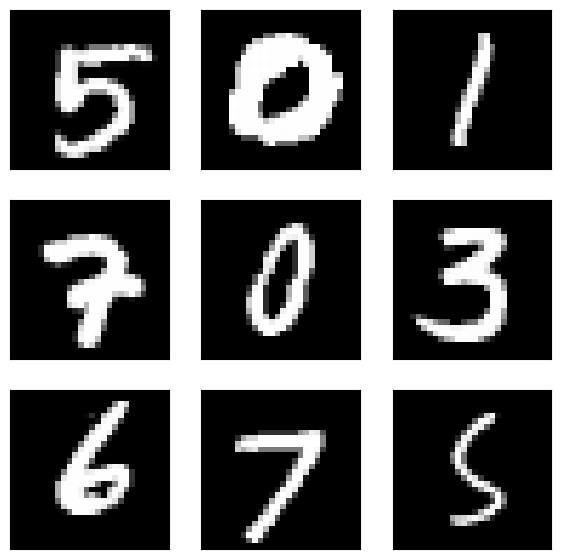

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt


data_iter = iter(train_loader)
image_batch, labels = next(data_iter)
image_batch = image_batch.numpy()

fig, axes = plt.subplots(figsize=(7,7), nrows=3, ncols=3, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), image_batch):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# The Fun Stuff™

Now we can get to architecture. For this particular experiment I will use a very shallow CNN. I'm not trying to get state of the art performance here so it's nice to not have to overthink things

# The Baseline 

This will be our CNN in question. We will use this solo model as the baseline on which to judge the second opinion models

In [13]:
import torch.nn as nn

class Solo_Expert(nn.Module):
    def __init__(self):
        super(Solo_Expert, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, kernel_size=3),                              
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size=3),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 5 * 5, 10)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.flatten(x)       
        output = self.fc1(x)
        return output    
    
#Check what device to use
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device = torch.device("mps" if use_mps else "cpu")
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Device is {device}")

solo_model = Solo_Expert().to(device)

Device is cuda


In [6]:
import torch.optim as optim

from tqdm import tqdm 
import datetime

target = "full"

optimizer = optim.SGD(solo_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
loss_fn = nn.CrossEntropyLoss() 

def training_loop(model, target, train_loader, val_loader, quiet=False):
    print(f"Beginning of training for target: {target}")

    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        total_val_loss = 0.0
        best_loss = 9999
        
        #Train
        for (imgs, labels) in tqdm(train_loader, desc="Training", disable=quiet):
            imgs = imgs.to(device)
            labels = labels.to(device)

            model.eval()

            out = model(imgs)
            loss = loss_fn(out, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        #Validate
        for (val_imgs, val_labels) in tqdm(val_loader, desc="Validation", disable=quiet):
            val_imgs = val_imgs.to(device)
            val_labels = val_labels.to(device)

            model.train(True)

            val_out = model(val_imgs)
            val_loss = loss_fn(val_out, val_labels)

            total_val_loss += val_loss.item()

        epoch_val_loss = total_val_loss / len(val_loader)
        epoch_loss = total_loss / len(train_loader)
            
        #Save the best model
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            torch.save(model.state_dict(), "data/" + f"MNIST_{target}.pth")

        # if epoch == 1 or epoch % 10 == 0:
        now = datetime.datetime.now()
        if quiet == True:
            pass
            # if epoch % 5 == 0:
            #     print(f"{now}\nEpoch {epoch}\ntr_loss {epoch_loss:.5}\nval_loss {epoch_val_loss:.5}\n")
        else:
            print(f"{now}\nEpoch {epoch}\ntr_loss {epoch_loss:.5}\nval_loss {epoch_val_loss:.5}\n")

In [ ]:
training_loop(solo_model, target, train_loader, val_loader)

And now to test the accuracy

In [7]:
def validate(model, val_loader):
    model.eval()
        
    for name, loader in [("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                labels = labels.to(device)

                outputs = model(imgs)

                # print("Out: " + str(outputs[0]))
                # print("Truth: " + str(labels[0]) + "\n")

                _, predicted = torch.max(outputs, dim=1)
                _, truth = torch.max(labels, dim=1)
                
                total += labels.shape[0]
                correct += int((predicted == truth).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [8]:
#Load model
solo_model.load_state_dict(torch.load(f"data/MNIST_full_[2023-05-20 14:06:48.644023].pth"))

#One hot encode
target_transform = transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
train_loader, val_loader = get_loaders(target_transform)

validate(solo_model, val_loader)

Accuracy val: 0.93


An ~93% accuracy might not be the knife's edge in terms of classification but it's a fair start.

# Second Opinion

Now that we have seen the performance of the baseline, we can compare it to a small horde of single-minded models. We will start by creating our own transform for labels.

In [9]:
#SLOW ?
class Relabel:
    def __init__(self, target):
        target = torch.zeros(10, dtype=torch.float).scatter_(
            dim=0, index=torch.tensor(target), value=1)

        self.target = target
    
    def __call__(self, label):
        if torch.equal(label, self.target) == True:
            return torch.Tensor(POSITIVE)
        else:
            return torch.Tensor(NEGATIVE)

Let's make a somewhat lobotomized version of our original expert that is a binary classifier

In [10]:
#Originally tried with less features than the original but it was bad

class Expert(nn.Module):
    def __init__(self):
        super(Expert, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, kernel_size=3),                              
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, kernel_size=3),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 5 * 5, 2)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.flatten(x)       
        output = self.fc1(x)
        return output    

Now let's modify the training for this hive mind

In [314]:
for target in range(0, 10):
    target_transform = transforms.Compose([
        transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)),
    Relabel(target)
    ])

    train_loader, val_loader = get_loaders(target_transform)
    hiveling = Expert()
    optimizer = optim.SGD(hiveling.parameters(), lr=LEARNING_RATE, momentum=0.9)

    training_loop(model=hiveling,
                target=target,
                train_loader=train_loader,
                val_loader=val_loader,
                quiet=True)

    validate(hiveling, val_loader)

Beginning of training for target: 0
Accuracy val: 0.99
Beginning of training for target: 1
Accuracy val: 0.99
Beginning of training for target: 2
Accuracy val: 0.98
Beginning of training for target: 3
Accuracy val: 0.98
Beginning of training for target: 4
Accuracy val: 0.98
Beginning of training for target: 5
Accuracy val: 0.97
Beginning of training for target: 6
Accuracy val: 0.99
Beginning of training for target: 7
Accuracy val: 0.98
Beginning of training for target: 8
Accuracy val: 0.98
Beginning of training for target: 9
Accuracy val: 0.97


Creating a class to contain all 10 models

In [11]:
class Hive(nn.Module):
    def __init__(self, hive_models):
        super(Hive, self).__init__()        

        self.hive_models = hive_models

    def forward(self, x):
        #Data loader might not have enough data for a full batch
        current_batch_size = x.shape[0]

        outputs = torch.zeros((current_batch_size, 10))
        for index, hiveling in enumerate(hive_models):
            out = hiveling(x)

            #Combining the output of all models into the correct shape
            outputs[:, index] = out[:, 0]
            
        return outputs

Let's evaluate them all at once now and see if this did anything

In [12]:
hive_models = []

target_transform = transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
train_loader, val_loader = get_loaders(target_transform)

for target in range(0, 10):
    hiveling = Expert()
    # soo_model.load_state_dict(torch.load(f"data/MNIST_full_[2023-05-20 13:37:37.751415].pth"))
    hiveling.load_state_dict(torch.load(f"data/MNIST_{target}.pth"))
    hive_models.append(hiveling)

hive = Hive(hive_models)

validate(hive, val_loader)

Accuracy val: 0.92


As well as individual performance if you forgot results from training

In [331]:
for target in range(0, 10):
    # print(target)
    target_transform = transforms.Compose([
        transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)),
    Relabel(target)
    ])

    train_loader, val_loader = get_loaders(target_transform)
    hiveling = Expert()

    hiveling.load_state_dict(torch.load(f"data/MNIST_{target}.pth"))

    validate(hiveling, val_loader)

Accuracy val: 0.99
Accuracy val: 0.99
Accuracy val: 0.98
Accuracy val: 0.98
Accuracy val: 0.98
Accuracy val: 0.97
Accuracy val: 0.99
Accuracy val: 0.98
Accuracy val: 0.98
Accuracy val: 0.97


# Conclusion
Unfortunately it did not work out that well. The overall performance tends to be the same or lower, at the cost massively slower training. There is still some potential use from this. If the classes were vastly different in difficulty creating a model tuned for the difficult problem might increase accuracy and prevent overfitting on the other classes. It might be enough if you are looking to juice out that extra half a percent of accuracy from the model and don't mind waiting. 